In [31]:
!pip install transformers

You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
import pandas as pd

df = pd.read_csv('train.csv')
df['ratings'] = df['ratings'] - 1 
df = df.sample(frac = 1)
df.head()

,Unnamed: 0,reviews,ratings
24230,24230,"Awesome price for a great product, can't beat ...",4
18402,18402,fast absorbing hand cream.but it has petrolium...,3
35879,35879,I love it. Can't believe what you miss with b...,4
14746,14746,Gets rid of the dead skin better than just a t...,3
1448,1448,these are just what i needed for my 1977 kawas...,4


In [33]:
df = df[['reviews', 'ratings']].head(1000)
df.head()

,reviews,ratings
24230,"Awesome price for a great product, can't beat ...",4
18402,fast absorbing hand cream.but it has petrolium...,3
35879,I love it. Can't believe what you miss with b...,4
14746,Gets rid of the dead skin better than just a t...,3
1448,these are just what i needed for my 1977 kawas...,4


In [34]:
from transformers import BertTokenizer

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [36]:
def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=128,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

In [37]:

import numpy as np

In [38]:

Xids = np.zeros((len(df), 128))
Xmask = np.zeros((len(df), 128))

In [39]:
for i, sequence in enumerate(df['reviews']):
    tokens = tokenize(sequence)
    Xids[i, :], Xmask[i, :] = tokens[0], tokens[1]

In [40]:
arr = df['ratings'].values

In [41]:
arr


array([4, 3, 4, 3, 4, 0, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4,
       1, 4, 2, 2, 1, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 2, 4, 4, 0,
       4, 4, 4, 4, 4, 4, 1, 0, 4, 1, 4, 4, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 3, 4, 0, 4,
       4, 4, 4, 4, 3, 4, 4, 0, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 3, 3, 4,
       4, 4, 3, 4, 3, 3, 3, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 0,
       4, 4, 4, 4, 0, 4, 0, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 2, 0, 4, 4, 3, 4, 4, 3, 0, 4, 4, 2, 4, 2, 3, 4, 3, 0,
       4, 4, 4, 3, 4, 0, 4, 0, 4, 1, 0, 4, 4, 4, 3, 4, 4, 4, 4, 2, 4, 2,
       4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 4, 3, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4,
       1, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 3, 4, 3, 1, 0, 1, 4, 0, 4, 4,
       4, 2, 3, 4, 4, 4, 2, 4, 3, 0, 4, 4, 0, 4, 2, 4, 4, 4, 3, 4, 4, 3,
       4, 4, 4, 1, 4, 4, 4, 3, 4, 2, 3, 0, 4, 4, 3,

In [42]:
labels = np.zeros((arr.size, arr.max()+1))

In [43]:
labels[np.arange(arr.size), arr] = 1


In [44]:
labels

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [45]:
import tensorflow as tf

In [46]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [47]:
data = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [48]:
SHUFFLE = 100000
BATCH_SIZE = 16

In [49]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [50]:

data = data.map(map_func)

In [51]:
data = data.shuffle(SHUFFLE).batch(BATCH_SIZE) #, drop_remainder=True)

In [52]:
SIZE = Xids.shape[0]/BATCH_SIZE
SIZE

62.5

In [53]:

SPLIT = 0.8

train = data.take(int(SIZE*SPLIT))
val = data.skip(int(SIZE*SPLIT))

del data

In [54]:
from transformers import TFAutoModel


In [55]:
bert = TFAutoModel.from_pretrained('bert-base-cased')  #, output_hidden_states=False


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [56]:
bert.summary()

Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [57]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[0]  # access final activations with [0]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.LSTM(32, dropout=.3, recurrent_dropout=.3, return_sequences=True)(embeddings)
x = tf.keras.layers.LSTM(16, dropout=.4, recurrent_dropout=.4, return_sequences=False)(x)
# normalize
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dense(64, activation='relu')(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [58]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128, 32)      102528      bert[0][0]            

In [59]:
optimizer = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [60]:
history = model.fit(
    train,
    validation_data=val,
    epochs=2
    )

Epoch 1/2
50/50 [==============================] - 198s 4s/step - loss: 1.0404 - accuracy: 0.6875 - val_loss: 1.0078 - val_accuracy: 0.6850
Epoch 2/2
50/50 [==============================] - 195s 4s/step - loss: 0.9607 - accuracy: 0.6875 - val_loss: 0.8228 - val_accuracy: 0.7150


In [61]:
model.get_config()

{'name': 'functional_3',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'input_ids'},
   'name': 'input_ids',
   'inbound_nodes': []},
  {'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'attention_mask'},
   'name': 'attention_mask',
   'inbound_nodes': []},
  {'class_name': 'Custom>TFBertMainLayer',
   'config': {'name': 'bert',
    'trainable': False,
    'dtype': 'float32',
    'config': {'return_dict': True,
     'output_hidden_states': False,
     'output_attentions': False,
     'torchscript': False,
     'use_bfloat16': False,
     'pruned_heads': {},
     'tie_word_embeddings': True,
     'is_encoder_decoder': False,
     'is_decoder': False,
     'add_cross_attention': False,
     'tie_encoder_decoder': False,
     'max_length': 20,
     'min_length': 0,
    

In [62]:
model.save('model.h5')


Testing


In [63]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=128,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [93]:
test = pd.read_csv('test.csv')
test = test.sample(frac = 1)
test = test[:1000]

In [94]:
test

,Unnamed: 0,reviews,ratings
8396,8396,I couldn't get past the smell of this unfortun...,2
6242,6242,I liked the product but after two weeks water ...,2
1444,1444,Packaging looked so bad it felt like I was buy...,1
1747,1747,"Serves it's purpose ok, and it was super cheap...",4
6729,6729,Definitely works. A must buy for anyone going ...,5
1649,1649,I these so much! I wear them out and about on ...,5
1141,1141,I love these wipes but I only buy them at Walm...,5
4743,4743,Smells so so good and lathers up so nice. Feel...,5
3853,3853,Love these! Great colors and for some reason t...,5
4370,4370,"Very light, but seems to work well. Not greasy.",5


In [95]:
test['Predicted'] = None

for i, row in test.iterrows():
    # get token tensors
    tokens = prep_data(row['reviews'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs) + 1
    # add to dataframe
    test.at[i, 'Predicted'] = pred

test.head()

,Unnamed: 0,reviews,ratings,Predicted
8396,8396,I couldn't get past the smell of this unfortun...,2,1
6242,6242,I liked the product but after two weeks water ...,2,1
1444,1444,Packaging looked so bad it felt like I was buy...,1,1
1747,1747,"Serves it's purpose ok, and it was super cheap...",4,5
6729,6729,Definitely works. A must buy for anyone going ...,5,5


In [96]:
test

,Unnamed: 0,reviews,ratings,Predicted
8396,8396,I couldn't get past the smell of this unfortun...,2,1
6242,6242,I liked the product but after two weeks water ...,2,1
1444,1444,Packaging looked so bad it felt like I was buy...,1,1
1747,1747,"Serves it's purpose ok, and it was super cheap...",4,5
6729,6729,Definitely works. A must buy for anyone going ...,5,5
1649,1649,I these so much! I wear them out and about on ...,5,5
1141,1141,I love these wipes but I only buy them at Walm...,5,5
4743,4743,Smells so so good and lathers up so nice. Feel...,5,5
3853,3853,Love these! Great colors and for some reason t...,5,5
4370,4370,"Very light, but seems to work well. Not greasy.",5,1


In [97]:
!pip install seaborn
!pip install sns

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [98]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import sns 
import seaborn

In [99]:
def report(y_pred,y_test):
    Classification_report = classification_report(y_test,y_pred,target_names=['1','2','3','4','5'])
    cm  = confusion_matrix(test['ratings'],y_pred)
    print("Classification Report : \n",Classification_report)
    print("Heat Map :\n")
    seaborn.heatmap(cm,cmap="Blues",annot=True,fmt='.4g',xticklabels=['1','2','3','4','5'],yticklabels=['1','2','3','4','5'])

/home/piyush/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
Classification Report : 
               precision    recall  f1-score   support

           1       0.43      0.77      0.55       128
           2       0.00      0.00      0.00        65
           3       0.00      0.00      0.00       102
           4       0.00      0.00      0.00       140
           5       0.70      0.95      0.80       565

    accuracy                           0.63      1000
   macro avg       0.22      0.34      0.27      1000
weighted avg       0.45      0.63      0.52      1000

Heat Map :



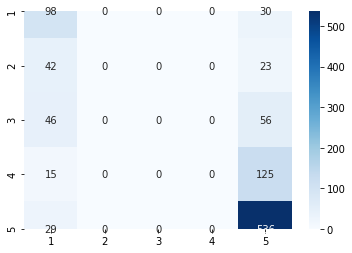

In [100]:
report(test["Predicted"].to_list(), test["ratings"].to_list())

In [71]:
import tensorflow as tf

model = tf.keras.models.load_model("model.h5")

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 768)     0           bert[0][0]                   